In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

import utils
import rdd_data_loader

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN
from torchvision.ops import MultiScaleRoIAlign

In [2]:
# Create the custom DINOv2 backbone
class DINOv2Backbone(nn.Module):
    def __init__(self, dinov2):
        super().__init__()
        self.dinov2 = dinov2
        self.out_channels = 768  # Define output channels for Faster R-CNN

        # Freeze all parameters in DINOv2
        for param in self.dinov2.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():  # Freeze DINOv2
            features = self.dinov2.get_intermediate_layers(x, n=1)[0]  # Extract feature maps

        # Reshape output from (B, Seq_len, C) -> (B, C, H, W)
        B, Seq_len, C = features.shape
        H = W = int(Seq_len ** 0.5)  # Assuming square feature maps
        features = features.permute(0, 2, 1).reshape(B, C, H, W)  # (B, 768, H, W)
        
        return features

# Create Faster R-CNN model with custom DINOv2 backbone
def create_fasterrcnn_model(dino_model, num_classes=7):
    # Get the custom DINOv2 backbone with out_channels attribute
    backbone = DINOv2Backbone(dino_model)
    
    # Generate the Region Proposal Network (RPN) and RoI Align
    rpn_anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),  # Anchor sizes
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Aspect ratios
    )
    
    # Set up the RoI Align layer
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )
    
    # Create the Faster R-CNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,  # Adjust based on your dataset
        rpn_anchor_generator=rpn_anchor_generator,
        box_roi_pool=roi_pooler,
        min_size=448,   # Minimum image size
        max_size=448,  # Maximum image size
    )
    
    return model

In [3]:
# Dataset, DataLoader, and Transforms

# DinoV2 transformation
dino_transform = v2.Compose([
        v2.Resize(512),
        v2.CenterCrop(448),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])


train_dataset = rdd_data_loader.RoadDamageDataset(csv_file='train_paths.csv', transforms=dino_transform)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, collate_fn=rdd_data_loader.collate_fn)

validation_dataset = rdd_data_loader.RoadDamageDataset(csv_file='val_paths.csv', transforms=dino_transform)
validation_dataloader = DataLoader(validation_dataset, batch_size=20, shuffle=True, collate_fn=rdd_data_loader.collate_fn)

c:\Users\citak\anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [23]:
def create_fasterrcnn_model_with_adapted_dimensions(dino_model, num_classes=7):
    # Create a custom backbone with dimension adaptation
    class DINOv2AdaptedBackbone(nn.Module):
        def __init__(self, dinov2):
            super().__init__()
            self.dinov2 = dinov2
            self.out_channels = 256  # Match COCO pretrained model dimensions
            
            # Add a projection layer to adapt dimensions from 768 -> 256
            self.projection = nn.Conv2d(768, 256, kernel_size=1)
            
            # Freeze DINOv2 parameters
            for param in self.dinov2.parameters():
                param.requires_grad = False

        def forward(self, x):
            with torch.no_grad():
                features = self.dinov2.get_intermediate_layers(x, n=1)[0]
            
            # Reshape from (B, Seq_len, C) -> (B, C, H, W)
            B, Seq_len, C = features.shape
            H = W = int(Seq_len ** 0.5)
            features = features.permute(0, 2, 1).reshape(B, C, H, W)
            
            # Project from 768 -> 256 channels
            features = self.projection(features)
            
            return features
    
    # Create the adapted backbone
    backbone = DINOv2AdaptedBackbone(dino_model)
    
    # Use the same anchor generator and RoI pooler settings as COCO models
    rpn_anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Match pretrained model
    )
    
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )
    
    # Create Faster R-CNN with adapted backbone
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=rpn_anchor_generator,
        box_roi_pool=roi_pooler,
        min_size=448,
        max_size=448,
    )
    
    # Now load the pretrained COCO model
    coco_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Transfer weights from components with matching dimensions
    pretrained_dict = coco_model.state_dict()
    model_dict = model.state_dict()
    
    # Filter out backbone and mismatched dimensions
    compatible_pretrained_dict = {k: v for k, v in pretrained_dict.items() 
                                 if k in model_dict and 
                                 k.startswith('rpn') and 
                                 v.shape == model_dict[k].shape}
    
    # Update box predictor weights separately (only if shapes match)
    if model_dict['roi_heads.box_head.fc6.weight'].shape[1] == pretrained_dict['roi_heads.box_head.fc6.weight'].shape[1]:
        compatible_pretrained_dict.update({'roi_heads.box_head.fc6.weight': pretrained_dict['roi_heads.box_head.fc6.weight'],
                                          'roi_heads.box_head.fc6.bias': pretrained_dict['roi_heads.box_head.fc6.bias'],
                                          'roi_heads.box_head.fc7.weight': pretrained_dict['roi_heads.box_head.fc7.weight'],
                                          'roi_heads.box_head.fc7.bias': pretrained_dict['roi_heads.box_head.fc7.bias']})
    
    # Update the model with compatible weights
    model_dict.update(compatible_pretrained_dict)
    model.load_state_dict(model_dict, strict=False)
    
    return model

class DINOv2AdaptedBackbone(nn.Module):
    def __init__(self, dinov2):
        super().__init__()
        self.dinov2 = dinov2
        self.out_channels = 256  # Match COCO pretrained model dimensions
        
        # Add a projection layer to adapt dimensions from 768 -> 256
        self.projection = nn.Conv2d(768, 256, kernel_size=1)
        
        # Freeze DINOv2 parameters
        for param in self.dinov2.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            features = self.dinov2.get_intermediate_layers(x, n=1)[0]

        print(features.shape)
        
        # Reshape from (B, Seq_len, C) -> (B, C, H, W)
        B, Seq_len, C = features.shape
        H = W = int(Seq_len ** 0.5)
        features = features.permute(0, 2, 1).reshape(B, C, H, W)
        
        # Project from 768 -> 256 channels
        features = self.projection(features)
        
        return features

# Load DINOv2 model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')


# Create the adapted backbone
backbone = DINOv2AdaptedBackbone(dino_model)

dummy_input = torch.ones((1,3, 224,224))
backbone_out = backbone(dummy_input)
print(f"Backbone out: {backbone_out.shape}")

features = torch.ones((1,256, 768))
B, Seq_len, C = features.shape
print(B, Seq_len, C)

H = W = int(Seq_len ** 0.5)
print(H, W)


a = features.permute(0, 2, 1)
print(a.shape)

features = features.permute(0, 2, 1).reshape(B, C, H, W)
print(features.shape)

In [24]:
## Model Initialization
use_pretrained = True

# Load DINOv2 model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

if use_pretrained:
    model = create_fasterrcnn_model_with_adapted_dimensions(dino_model, num_classes=7)
else:
    model = create_fasterrcnn_model(dino_model, num_classes=7)  # 7 classes

Using cache found in C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main
c:\Users\citak\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\citak\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Count parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

# Set the model to train mode
model.train()

Trainable parameters: 14737774
Non-trainable parameters: 86580480


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(448,), max_size=448, mode='bilinear')
  )
  (backbone): DINOv2AdaptedBackbone(
    (dinov2): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): 

In [26]:
# Define training function
def train_one_epoch(model, train_loader, optimizer, epoch, print_freq=50):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1}")
    for batch_idx, (images, targets) in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        avg_loss = total_loss / (batch_idx + 1)

        if batch_idx % print_freq == 0:
            pbar.set_postfix(loss=avg_loss)

    return avg_loss


def validate(model, data_loader):
    model.train()  # Temporarily set to train mode to compute losses
    
    # Loss accumulators
    total_loss = 0.0
    total_loss_classifier = 0.0
    total_loss_box_reg = 0.0
    total_loss_objectness = 0.0
    total_loss_rpn_box_reg = 0.0
    
    # Create progress bar
    num_batches = len(data_loader)
    pbar = tqdm(enumerate(data_loader), total=num_batches, desc="Validation")
    
    with torch.no_grad():  # No gradients needed for validation
        for batch_idx, (images, targets) in pbar:
            # Move images and targets to the device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass with loss computation 
            loss_dict = model(images, targets)
            
            # Calculate batch loss
            batch_loss = sum(loss for loss in loss_dict.values()).item()
            
            # Accumulate the different loss components
            total_loss += batch_loss
            total_loss_classifier += loss_dict['loss_classifier'].item()
            total_loss_box_reg += loss_dict['loss_box_reg'].item()
            total_loss_objectness += loss_dict['loss_objectness'].item()
            total_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()
            
            # Update progress bar with current loss
            pbar.set_postfix(loss=f"{batch_loss:.4f}")
    
    # Set back to evaluation mode
    model.eval()
    
    # Calculate averages
    avg_loss = total_loss / num_batches
    avg_loss_classifier = total_loss_classifier / num_batches
    avg_loss_box_reg = total_loss_box_reg / num_batches
    avg_loss_objectness = total_loss_objectness / num_batches
    avg_loss_rpn_box_reg = total_loss_rpn_box_reg / num_batches
    
    # Compile results
    val_metrics = {
        'val_loss': avg_loss,
        'val_loss_classifier': avg_loss_classifier,
        'val_loss_box_reg': avg_loss_box_reg,
        'val_loss_objectness': avg_loss_objectness,
        'val_loss_rpn_box_reg': avg_loss_rpn_box_reg
    }

    print(val_metrics)
    print('-'*30)
    
    return avg_loss

In [ ]:
num_epochs = 10
lr = 0.0002 # 0.0001
gamma = 0.95  # Exponential decay factor
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00005)

if use_pretrained:
    save_path = "dino_rcnn_models_pretrained"
else:
    save_path = "dino_rcnn_models"

best_val_loss = float("inf")
best_epoch = -1  # Track best epoch

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_dataloader, optimizer, epoch)
    val_loss = validate(model, validation_dataloader)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1  # Store best epoch number
        torch.save(model.state_dict(), save_path + "/best_fasterrcnn_dinov2.pth")
        print(f"Saved Best Model at Epoch {best_epoch}")

    # Save model every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), save_path + f"/fasterrcnn_dinov2_epoch{epoch+1}.pth")
        print(f"Saved model at Epoch {epoch+1}")

    # Apply learning rate decay
    scheduler.step()
    print(f"Updated Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest Model Found at Epoch {best_epoch} with Val Loss {best_val_loss:.4f}")


Epoch 1/10


Epoch 1:   0%|          | 0/1043 [00:00<?, ?it/s]c:\Users\citak\Desktop\RoadAnalysis\rdd_data_loader.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "boxes": torch.tensor(boxes, dtype=torch.float32),
Epoch 1:  21%|██        | 219/1043 [07:50<29:31,  2.15s/it, loss=347]    


KeyboardInterrupt: 

### Make a prediction with a single image

In [13]:
# Load the trained model

# Load DINOv2 model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

# Load DINOv2 model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

if use_pretrained:
    loaded_model = create_fasterrcnn_model_with_adapted_dimensions(dino_model, num_classes=7)
    loaded_model.load_state_dict(torch.load("dino_rcnn_models_pretrained/best_fasterrcnn_dinov2.pth", map_location=device))  # Load weights

else:
    loaded_model = create_fasterrcnn_model(dino_model, num_classes=7)  # 7 classes
    loaded_model.load_state_dict(torch.load("dino_rcnn_models_scratch/best_fasterrcnn_dinov2.pth", map_location=device))  # Load weights


loaded_model.to(device)
loaded_model.eval()  # Set model to evaluation mode

Using cache found in C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main
c:\Users\citak\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\citak\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(448,), max_size=448, mode='bilinear')
  )
  (backbone): DINOv2AdaptedBackbone(
    (dinov2): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): 

### Available Classes ###

D00 - Longitudinal Crack<br>
D10 - Transverse Crack<br>
D20 - Alligator Crack<br>
D40 - Pothole<br>
D43 - Repair<br>
D44 - White Line Disconnection<br>
D50 - Bleeding<br>


D00 - Boyuna Çatlak<br>
D10 - Enine Çatlak<br>
D20 - Timsah Derisi Çatlağı<br>
D40 - Çukur (Asfalt Bozulması)<br>
D43 - Onarım<br>
D44 - Beyaz Çizgi Kopması<br>
D50 - Asfalt Kusması (Kanama)<br>

In [30]:
class_2_idx = {'D00':0, 'D10':1, 'D20':2, 'D40':3, 'D43':4, 'D44':5, 'D50':6 }
idx_2_class = {v: k for k, v in class_2_idx.items()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(640, 640) torch.Size([3, 448, 448])


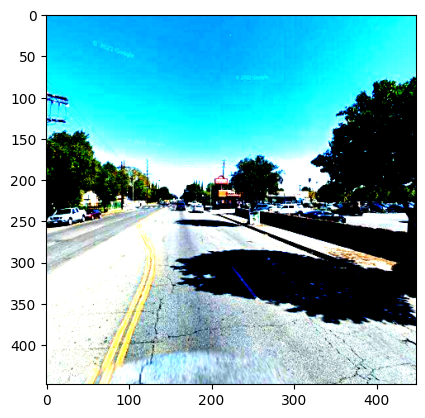

In [31]:
## Define transforms, read image and make it ready for prediction

# DinoV2 transformation
dino_transform = v2.Compose([
        v2.Resize(512),
        v2.CenterCrop(448),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

image_path = r"C:\RDD2022\RDD2022\United_States\train\images\United_States_000001.jpg"
image = Image.open(image_path).convert("RGB")  # Load image and convert to RGB
image_tensor = dino_transform(image)

print(image.size, image_tensor.shape)
plt.imshow(image_tensor.cpu().numpy().transpose(1,2,0))

In [32]:
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():  # Disable gradients for inference
    prediction = loaded_model(image_tensor)

print("Prediction: {}".format(prediction))

Prediction: [{'boxes': tensor([[262.5489, 302.2619, 425.2240, 448.0000],
        [  0.0000, 295.6348, 245.2777, 448.0000],
        [236.1181, 376.5749, 428.3764, 448.0000],
        [333.6508, 329.7816, 442.4593, 448.0000],
        [329.6335, 398.7173, 419.0277, 448.0000],
        [121.1982, 312.8550, 164.3314, 443.9203],
        [ 95.5985, 313.7939, 410.8995, 448.0000]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 2], device='cuda:0'), 'scores': tensor([0.1757, 0.1498, 0.0876, 0.0793, 0.0693, 0.0615, 0.0544],
       device='cuda:0')}]
